In [1]:
import datajoint as dj

In [2]:
dj.config['database.host'] = 'tutorial-db.datajoint.io'
dj.config['database.user'] = 'chris'

In [3]:
schema = dj.schema('tutorial', locals())

Please enter DataJoint password: ········
Connecting chris@tutorial-db.datajoint.io:3306


In [4]:
@schema
class Mouse(dj.Manual):
      definition = """
      mouse_id: int               # unique mouse id
      ---
      dob: date                   # mouse date of birth
      sex: enum('M', 'F', 'U')    # sex of mouse - Male, Female, or Unknown/Unclassified
      """

In [5]:
mouse = Mouse()

In [6]:
mouse.insert1( (0, '2017-03-01', 'M') )

In [7]:
data = {
  'mouse_id': 100,
  'dob': '2017-05-12',
  'sex': 'F'
}

In [8]:
mouse.insert1(data)

In [9]:
data = [
  (1, '2016-11-19', 'M'),
  (2, '2016-11-20', 'U'),
  (5, '2016-12-25', 'F')
]

# now insert all at once
mouse.insert(data)

In [10]:
data = [
  {'mouse_id': 10, 'dob': '2017-01-01', 'sex': 'F'},
  {'mouse_id': 11, 'dob': '2017-01-03', 'sex': 'F'},
]

# insert them all
mouse.insert(data)

In [11]:
 @schema
 class Session(dj.Manual):
     definition = """
     # experiment session
     -> Mouse
     session_date: date            # session date
     ---
     experiment_setup: int         # experiment setup ID
     experimenter: varchar(128)    # name of the experimenter
     """

In [12]:
session = Session()

In [13]:
data = {
      'mouse_id': 0,
      'session_date': '2017-05-15',
      'experiment_setup': 0,
      'experimenter': 'Edgar Y. Walker'
    }
session.insert1(data)

In [14]:
session.insert([
    {'mouse_id': 0, 
     'session_date': '2017-05-19',
     'experiment_setup': 0, 
     'experimenter': 'Edgar Y. Walker'},
    {'mouse_id': 100,
     'session_date': '2017-05-25',
     'experiment_setup': 1,
     'experimenter': 'Fabian Sinz'
    },
    {'mouse_id': 5,
     'session_date': '2017-01-05',
     'experiment_setup': 1,
     'experimenter': 'Jake Reimer'
    },
])

In [15]:
import numpy as np

In [16]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    ---
    activity:  longblob    # electric activity of the neuron
    """

    def _make_tuples(self, key):
        # use key dictionary to determine the data file path
        data_file = "./data/data_{mouse_id}_{session_date}.npy".format(**key)

        # load the data
        data = np.load(data_file)

        # add the loaded data as the "activity" column
        key['activity'] = data

        # insert the key into self
        self.insert1(key)

        print('Populated a neuron for {mouse_id} on {session_date}'.format(**key))


In [17]:
neuron = Neuron()

In [18]:
neuron.populate()

Populated a neuron for 0 on 2017-05-15
Populated a neuron for 0 on 2017-05-19
Populated a neuron for 5 on 2017-01-05
Populated a neuron for 100 on 2017-05-25


In [19]:
@schema
class ActivityStatistics(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean: float    # mean activity
    stdev: float   # standard deviation of activity
    max: float     # maximum activity
    """

    def _make_tuples(self, key):
        activity = (Neuron() & key).fetch1('activity')    # fetch activity as NumPy array

        # compute various statistics on activity
        key['mean'] = activity.mean()   # compute mean
        key['stdev'] = activity.std()   # compute standard deviation
        key['max'] = activity.max()     # compute max
        self.insert1(key)
        print('Computed statistics for mouse_id {mouse_id} session_date {session_date}'.format(**key))


In [20]:
stats = ActivityStatistics()

In [21]:
@schema
class SpikeDetectionParam(dj.Lookup):
    definition = """
    sdp_id: int      # unique id for spike detection parameter set
    ---
    threshold: float   # threshold for spike detection
    """


In [22]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """

    def _make_tuples(self, key):
        print('Populating for: ', key)

        activity = (Neuron() & key).fetch1('activity')
        threshold = (SpikeDetectionParam() & key).fetch1('threshold')

        above_thrs = (activity > threshold).astype(np.int)   # find activity above threshold
        rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
        spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff
        count = spikes.sum()   # compute total spike counts
        print('Detected {} spikes!\n'.format(count))

        # save results and insert
        key['spikes'] = spikes
        key['count'] = count
        self.insert1(key)


In [23]:
sdp = SpikeDetectionParam()

In [24]:
sdp.insert1({'sdp_id': 0, 'threshold': 0.9})

In [25]:
spikes = Spikes()

In [26]:
spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'sdp_id': 0}
Detected 27 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'sdp_id': 0}
Detected 21 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'sdp_id': 0}
Detected 14 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'sdp_id': 0}
Detected 35 spikes!



In [27]:
sdp.insert1({'sdp_id': 1, 'threshold': 0.1})

In [28]:
spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'sdp_id': 1}
Detected 128 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'sdp_id': 1}
Detected 135 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'sdp_id': 1}
Detected 132 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'sdp_id': 1}
Detected 142 spikes!



In [29]:
sdp.insert1({'sdp_id': 2, 'threshold': 1.3})

In [30]:
spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'sdp_id': 2}
Detected 13 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'sdp_id': 2}
Detected 5 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'sdp_id': 2}
Detected 1 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'sdp_id': 2}
Detected 9 spikes!



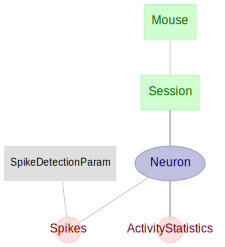

In [31]:
dj.ERD(schema)